# Predicting and understanding viewer engagement with educational videos 

## Description
Note that this code was written for the final project for the Online Coursera Course "Applied Machine Learning in Python" by Kevyn Collins-Thompson. Preprocessing and Classifiers were developed to predict the binary engagement label from a subset of the provided features. Performance of several different estimators were compared and hyperparameter tuning was also performed. Finally a random forest classifier was chosen.

## About the prediction problem

With the accelerating popularity of online educational experiences, the role of online lectures and other educational video continues to increase in scope and importance. Open access educational repositories such as <a href="http://videolectures.net/">videolectures.net</a>, as well as Massive Open Online Courses (MOOCs) on platforms like Coursera, have made access to many thousands of lectures and tutorials an accessible option for millions of people around the world. Yet this impressive volume of content has also led to a challenge in how to find, filter, and match these videos with learners. This assignment gives you an example of how machine learning can be used to address part of that challenge.

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. For this assignment, your task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

## About the dataset

The original datasets were provided as two csv files which were then preprocessed into pandas dataframes df_train and df_test and saved into pickle files.
**Data fields**

df_train & df_test:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
df_train only:
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.

In [12]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   # Do not change this value: required to be compatible with solutions generated by the autograder.

In [13]:
# Pre-Process the data
# df_train  = pd.read_csv('OriginalData/train.csv')
# df_train.to_pickle("df_train.pkl")
# df_test = pd.read_csv('OriginalData/test.csv')
# df_test.to_pickle("df_test.pkl")

Analyze the input fetures visually search for correlations and predictive capabalities of various features.

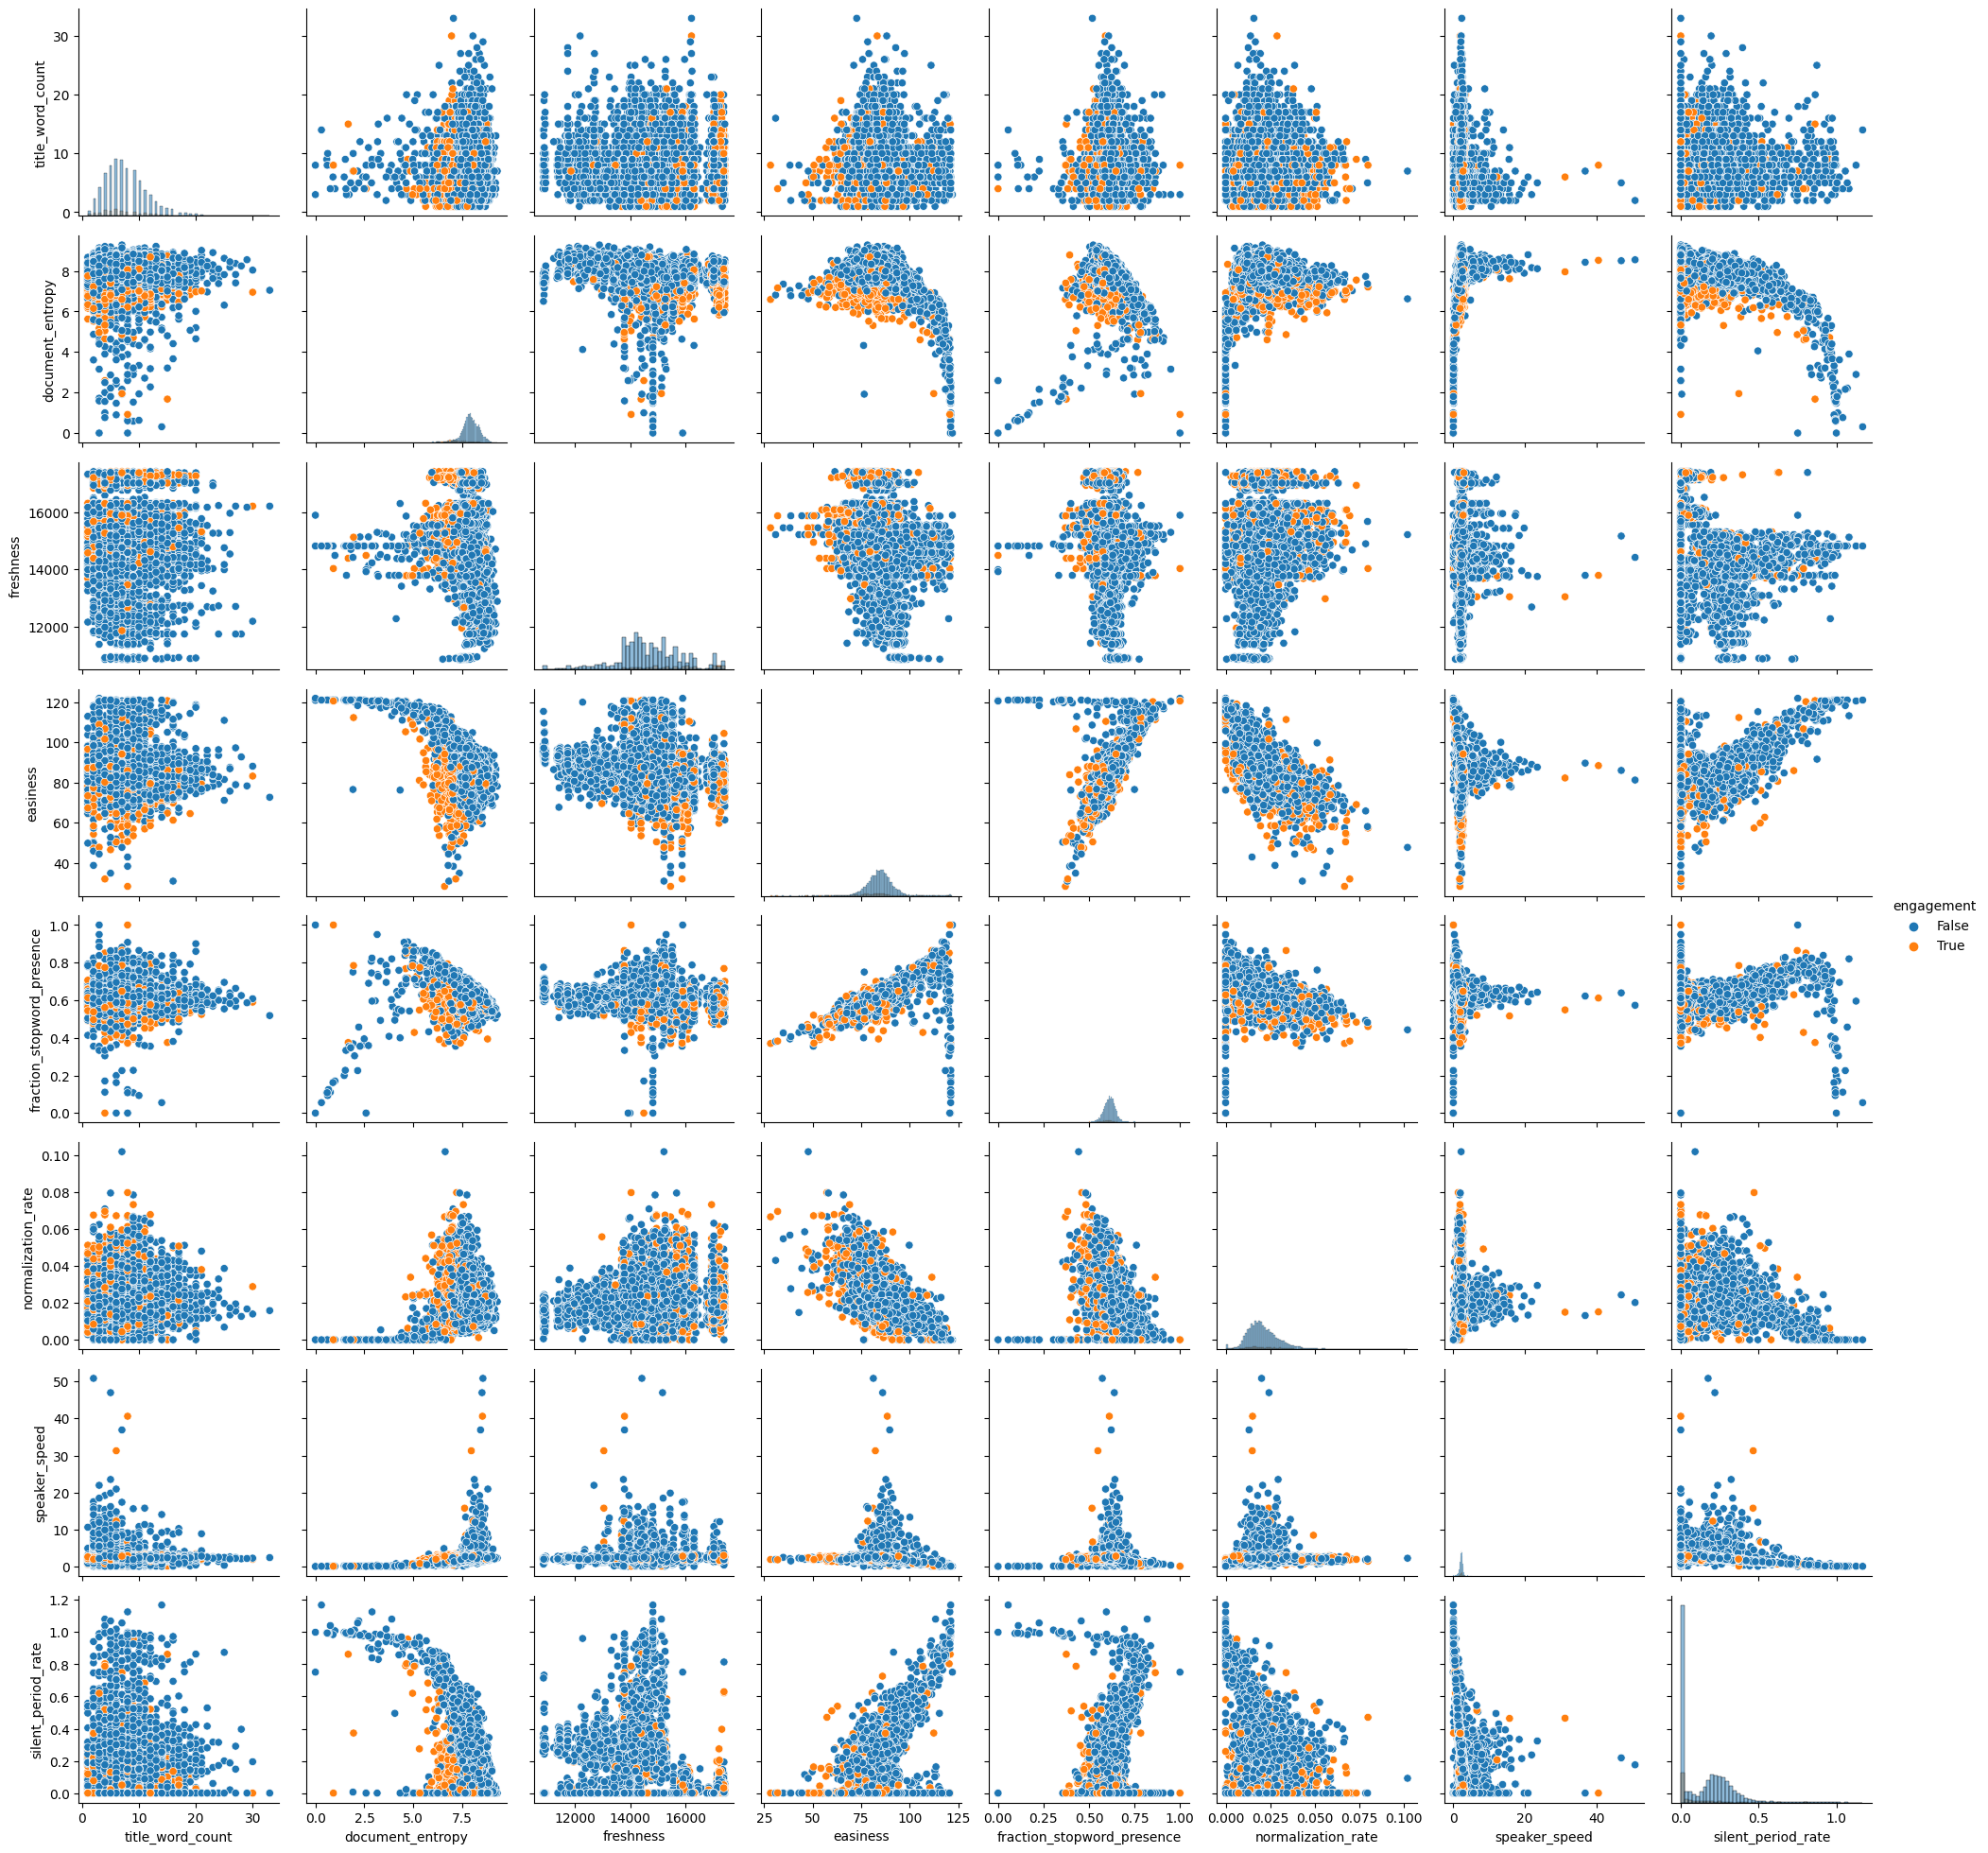

In [14]:
import seaborn as sns

df_train  = pd.read_pickle("df_train.pkl")

g = sns.PairGrid(df_train.drop(columns= ['id' ]),hue ='engagement')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [15]:
# Imports
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

Based on the features plot it was decided that speaker_speed and silent_period_rate were not too predictive of the target label (they did not show much separation in the label colors) and could be dropped from the input feature list.

In [16]:
# First attempt at with  
df_train  = pd.read_pickle("df_train.pkl")
dropcols = ['id','speaker_speed','silent_period_rate'] #Columns to be dropped

dropcols_train= dropcols.copy()
dropcols_train.append('engagement')
colsel_train = ColumnTransformer(transformers=[('drop','drop',dropcols_train)],remainder ='passthrough')

It was decided to attempt a classification with a Gaussian Naive BayesClassifier as a first step, which would also serve as a test case to develop a pipeline for the classification. A MinMax scaler was used for normalizing the input data.

In [17]:
pipeline = Pipeline(steps = [('scaler',MinMaxScaler()), 
                            ('estimator',GaussianNB(priors=None))])

X = colsel_train.fit_transform(df_train)
print(X.shape)
y = df_train['engagement']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipeline.fit(X_train, y_train)
y_pred =  pipeline.predict(X_test)

(9239, 6)


A function is written to obtain the area under the curve (AUC) for the receiver operating characteristic (ROC) curve. This serves as the main evaluation metric of the predictor in this problem.

In [18]:
# Function to get area under ROC curve for a given pipeline
def get_auc(pipeline_clf,X_test,y_test):
    indexTrue = np.where(pipeline_clf.classes_ == True)[0][0]
    p_pred =  pipeline.predict_proba(X_test)[:,indexTrue]
    fpr_test, tpr_test, _ = roc_curve(y_test, p_pred, pos_label = True)
    auc_test = auc(fpr_test, tpr_test)
    return auc_test

We can now evaluate the accuracy and AUC for the GaussianNB estimator

In [19]:

print('Accuracy of GaussianNB pipeline on training set: {:.2f}'
     .format(pipeline.score(X_train, y_train)))
print('Accuracy of GaussianNB pipeline on test set: {:.2f}'
     .format(pipeline.score(X_test, y_test)))
print('AUC of GaussianNB classifier on training set: {:.2f}'
     .format(get_auc(pipeline,X_train,y_train)))
print('AUC of GaussianNB classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test,pipeline.predict_proba(X_test)[:,1])))

Accuracy of GaussianNB pipeline on training set: 0.89
Accuracy of GaussianNB pipeline on test set: 0.88
AUC of GaussianNB classifier on training set: 0.82
AUC of GaussianNB classifier on test set: 0.80


A Grid Search with Cross-Validation on the training set is performed to attemp to find paramters which may improve the classifer.

In [20]:
parameters = {
    'estimator__var_smoothing':np.logspace(3,-9, num=10)
}

Bayes = GridSearchCV(pipeline, param_grid=parameters, scoring = 'roc_auc', cv=3).fit(X_train, y_train)
# print(Bayes.best_estimator_)
print('best score:{}'.format(Bayes.best_score_))
print('best params:\n{}'.format(Bayes.best_params_))
print('AUC of tuned GaussianNB classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, Bayes.best_estimator_.predict_proba(X_test)[:,1])))

best score:0.8219429701376089
best params:
{'estimator__var_smoothing': 0.004641588833612782}
AUC of tuned GaussianNB classifier on test set: 0.80


It is seen that the AUC values of the GaussianNB don't inmprove much with the GridSearchCV either. It was decided to use the previously developed pipeline with many different estimators to compare and contrast their prediction capabilities via the AUCs.

Fitting classifier :Nearest Neighbors
Fitting classifier :RBF SVM
Fitting classifier :Random Forest
Fitting classifier :Naive Bayes
Fitting classifier :Neural Net
Fitting classifier :AdaBoost
Fitting classifier :Gradient Boost


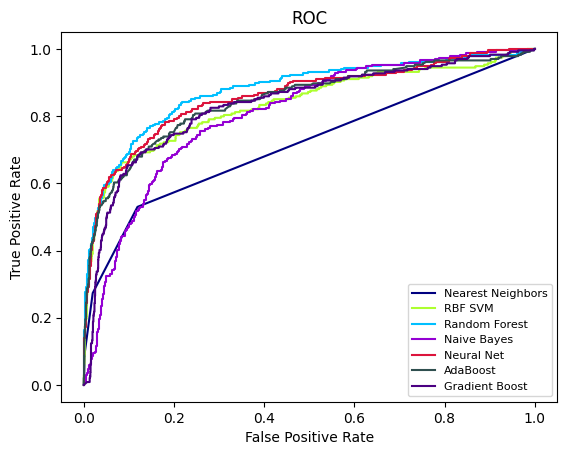

[0.7171705943382244, 0.8358467961069118, 0.8777954811191805, 0.8052303081204816, 0.8595733906427546, 0.8480394578660475, 0.8347248983087134]
Accuracy of classifiers on training set:
[0.9444364266127868, 0.9222109972579016, 0.965218646269303, 0.889883100014432, 0.9302929715687689, 0.9334680329051811, 0.9946601241160341]


Accuracy of classifiers on test set:
[0.9086580086580086, 0.9147186147186147, 0.9277056277056277, 0.8861471861471861, 0.9207792207792208, 0.9264069264069265, 0.9051948051948052]


AUC of classifiers on training set:
[0.9749039442436112, 0.8524869546630309, 0.9848855105891212, 0.8212063091336859, 0.8759651912521742, 0.9146526370620923, 0.9977572948696285]


AUC of classifiers on test set:
[0.7171705943382244, 0.8358467961069118, 0.8777954811191805, 0.8052303081204816, 0.8595733906427546, 0.8480394578660475, 0.8347248983087134]




In [21]:
names = [
    "Nearest Neighbors",
    "RBF SVM",
    "Random Forest",
    "Naive Bayes",
    "Neural Net",
    "AdaBoost",
    "Gradient Boost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(gamma=2, C=1, probability = True),
    RandomForestClassifier(max_depth=10, n_estimators=100, max_features=2),
    GaussianNB(),
    MLPClassifier(alpha=0.00001, max_iter=10000),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators= 200, learning_rate=1.0,max_depth=3, random_state=0)]

# Get different color each graph line
colorSet = ['navy', 'greenyellow', 'deepskyblue', 'darkviolet', 'crimson', 
    'darkslategray', 'indigo', 'brown', 'orange', 'palevioletred', 'mediumseagreen',
    'k', 'darkgoldenrod', 'g', 'midnightblue', 'c', 'y', 'r', 'b', 'm', 'lawngreen'
    'mediumturquoise', 'lime', 'teal', 'drive', 'sienna', 'sandybrown']

# Create test train data
df_train  = pd.read_pickle("df_train.pkl")
dropcols = ['id'] #,'speaker_speed','silent_period_rate']
dropcols_train= dropcols.copy()
dropcols_train.append('engagement')
colsel_train = ColumnTransformer(transformers=[('drop','drop',dropcols_train)],remainder ='passthrough')
X = colsel_train.fit_transform(df_train)
y = df_train['engagement']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# iterate over classifiers
clf_train_accuracy = []
clf_test_accuracy = []
clf_train_auc = []
clf_test_auc = []

plt.figure(1)
plt.title('ROC')
count = 0
for name, clf in zip(names, classifiers):
    print("Fitting classifier :{}".format(name))
    pipeline_clf = Pipeline(steps = [('scaler',MinMaxScaler()), 
                                ('estimator',clf)])
    
    pipeline_clf.fit(X_train, y_train)
    
    # y_pred =  pipeline_clf.predict(X_test)
    
    indexTrue = np.where(pipeline_clf.classes_ == True)[0][0]
    p_pred =  pipeline_clf.predict_proba(X_test)[:,indexTrue]
    fpr_test, tpr_test, _ = roc_curve(y_test, p_pred, pos_label = True)
    auc_test = auc(fpr_test, tpr_test)
    
    clf_train_accuracy.append(pipeline_clf.score(X_train,y_train))
    clf_test_accuracy.append(pipeline_clf.score(X_test,y_test))
    clf_train_auc.append(roc_auc_score(y_train, pipeline_clf.predict_proba(X_train)[:,indexTrue]))
    clf_test_auc.append(roc_auc_score(y_test, pipeline_clf.predict_proba(X_test)[:,indexTrue]))
    
    plt.figure(1)
    plt.plot(fpr_test, tpr_test, c=colorSet[count], label = name)
    count +=1

plt.legend(names,loc='lower right', prop={'size':8})
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(clf_test_auc)

# Save ROC graphs
# plt.savefig('modles.jpg')
print('Accuracy of classifiers on training set:')
print(clf_train_accuracy)
print('\n')

print('Accuracy of classifiers on test set:')
print(clf_test_accuracy)
print('\n')

print('AUC of classifiers on training set:')
print(clf_train_auc)
print('\n')

print('AUC of classifiers on test set:')
print(clf_test_auc)
print('\n')  


It appears that the Neural Net (NN) and Random Forest (RF) classifiers have the best AUCs and these two are chosen for parameter tuning (with GridSearchCV) below. Care was taken here to not tune the parameters too agressively and overfit the training data.

In [22]:
# Neural Net pipeline and Hyperparameter tuning
pipeline_NN = Pipeline(steps = [('scaler',MinMaxScaler()), 
                                ('estimator',MLPClassifier())])
parameters = {
    'estimator__alpha':[1e-6, 1e-3, 1],
    'estimator__max_iter':[1000,5000,8000],
}

gs = GridSearchCV(pipeline_NN, param_grid=parameters, scoring = 'roc_auc', cv=3).fit(X_train, y_train)

print('best score:{}'.format(gs.best_score_))
print('best params:\n{}'.format(gs.best_params_))
print('AUC of tuned NN classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, gs.best_estimator_.predict_proba(X_test)[:,1])))
print('Test Scores:\n{}',format(np.reshape(gs.cv_results_['mean_test_score'],(3,3))))

best score:0.8699505912424299
best params:
{'estimator__alpha': 1e-06, 'estimator__max_iter': 5000}
AUC of tuned NN classifier on test set: 0.86
Test Scores:
{} [[0.86760453 0.86995059 0.86875759]
 [0.86888857 0.86920672 0.86750528]
 [0.79860359 0.79890884 0.79907037]]


In [23]:
# Random Forest pipeline and Hyperparameter tuning
pipeline_RF = Pipeline(steps = [('scaler',MinMaxScaler()), 
                                ('estimator',RandomForestClassifier(max_features=3))])
parameters = {
    'estimator__n_estimators': [500,1000],
    'estimator__max_depth': range(5,8)
}

gs_RF = GridSearchCV(pipeline_RF, param_grid=parameters, scoring = 'roc_auc', cv=5, return_train_score=True).fit(X_train, y_train)

print('best score:{}'.format(gs_RF.best_score_))
print('best params:\n{}'.format(gs_RF.best_params_))
print('AUC of tuned RF classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, gs_RF.best_estimator_.predict_proba(X_test)[:,1])))
print('Train Scores:\n{}',format(np.reshape(gs_RF.cv_results_['mean_train_score'],(2,3))))
print('Test Scores:\n{}',format(np.reshape(gs_RF.cv_results_['mean_test_score'],(2,3))))
print(gs_RF.cv_results_.keys())

It is seen after some experimentation with hyperparameter tuning, that the RF classifiler performs slightly better than the NN and it is chosen for the final model which is then trained on all available data with parameters determined from the GridSearchCV.

In [ ]:
def engagement_model():
    df_train  = pd.read_pickle("df_train.pkl")
    dropcols = ['id']

    dropcols_train= dropcols.copy()
    dropcols_train.append('engagement')
    colsel_train = ColumnTransformer(transformers=[('drop','drop',dropcols_train)],remainder ='passthrough')
    X = colsel_train.fit_transform(df_train)
    y = df_train['engagement']
    
    classifier = Pipeline(steps = [('scaler',MinMaxScaler()), 
                                ('estimator',RandomForestClassifier(n_estimators=1000,max_features=3,max_depth=5))])
    
    classifier.fit(X, y)
    
    df_test = pd.read_pickle("df_test.pkl")
    ans_ids = df_test['id']
    colsel_ans = ColumnTransformer(transformers=[('drop','drop',dropcols)],remainder ='passthrough')
    X_ans = colsel_ans.fit_transform(df_test) 

    indexTrue = np.where(classifier.classes_ == True)[0][0]
    rec =  pd.Series(classifier.predict_proba(X_ans)[:,indexTrue],index = ans_ids)
    rec.rename('engagement',inplace = True)
    return rec

In [ ]:
engagement_model()

id
9240     0.033090
9241     0.040993
9242     0.105844
9243     0.723486
9244     0.035334
           ...   
11544    0.025031
11545    0.017654
11546    0.018757
11547    0.763935
11548    0.022767
Name: engagement, Length: 2309, dtype: float64